<a href="https://colab.research.google.com/github/rareshnz/Licenta_Ciuperci/blob/main/ResNet50_ciuperci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
dataset_path = "/content/drive/MyDrive/Mushrooms"


categories = os.listdir(dataset_path)
num_categories = len(categories)
X = []
y = []

In [ ]:
for idx, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(idx)

X = np.array(X)
y = np.array(y)

In [ ]:
X_preprocessed = preprocess_input(X)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)
X_val = preprocess_input(X_val)


In [ ]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history=model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])



94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
239/239 [==============================] - 88s 318ms/step - loss: 9.8012 - accuracy: 0.4129 - val_loss: 7.7520 - val_accuracy: 0.4777
Epoch 2/50
239/239 [==============================] - 72s 302ms/step - loss: 6.6470 - accuracy: 0.5397 - val_loss: 6.0563 - val_accuracy: 0.4735
Epoch 3/50
239/239 [==============================] - 72s 303ms/step - loss: 5.1042 - accuracy: 0.5892 - val_loss: 4.9091 - val_accuracy: 0.5066
Epoch 4/50
239/239 [==============================] - 73s 305ms/step - loss: 4.1252 - accuracy: 0.6159 - val_loss: 4.1976 - val_accuracy: 0.4987
Epoch 5/50
239/239 [==============================] - 72s 301ms/step - loss: 3.4542 - accuracy: 0.6386 - val_loss: 3.7130 - val_accuracy: 0.5081
Epoch 6/50
239/239 [==============================] - 72s 301ms/step - loss: 2.9594 - accuracy: 0.6659 - val_loss: 3.4152 - val_accuracy: 0.5113
Epoch 7/50
239/239 [==============================] - 72s 302ms/s

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


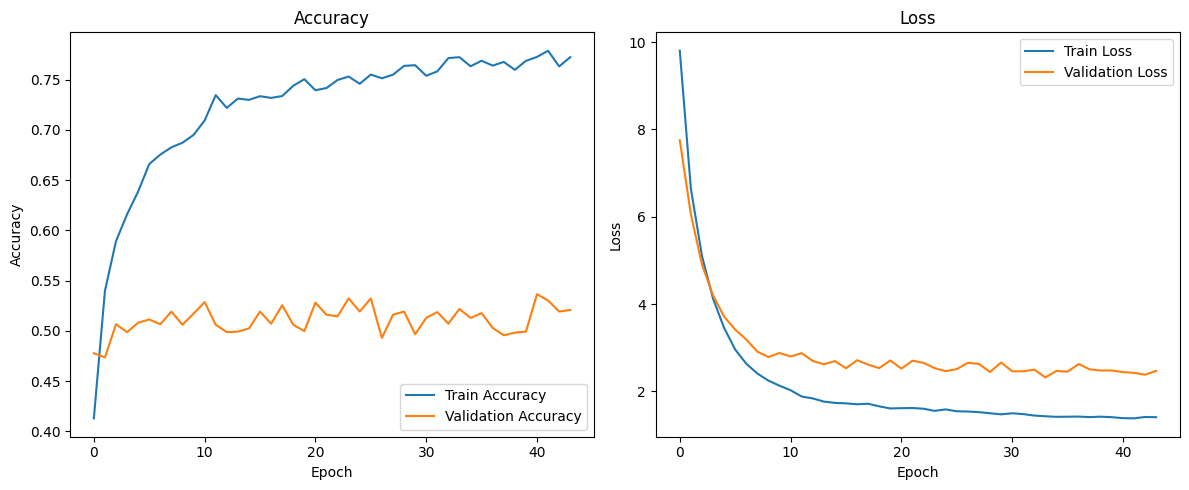

In [ ]:
plot_training_history(history)

60/60 [==============================] - 2s 17ms/step


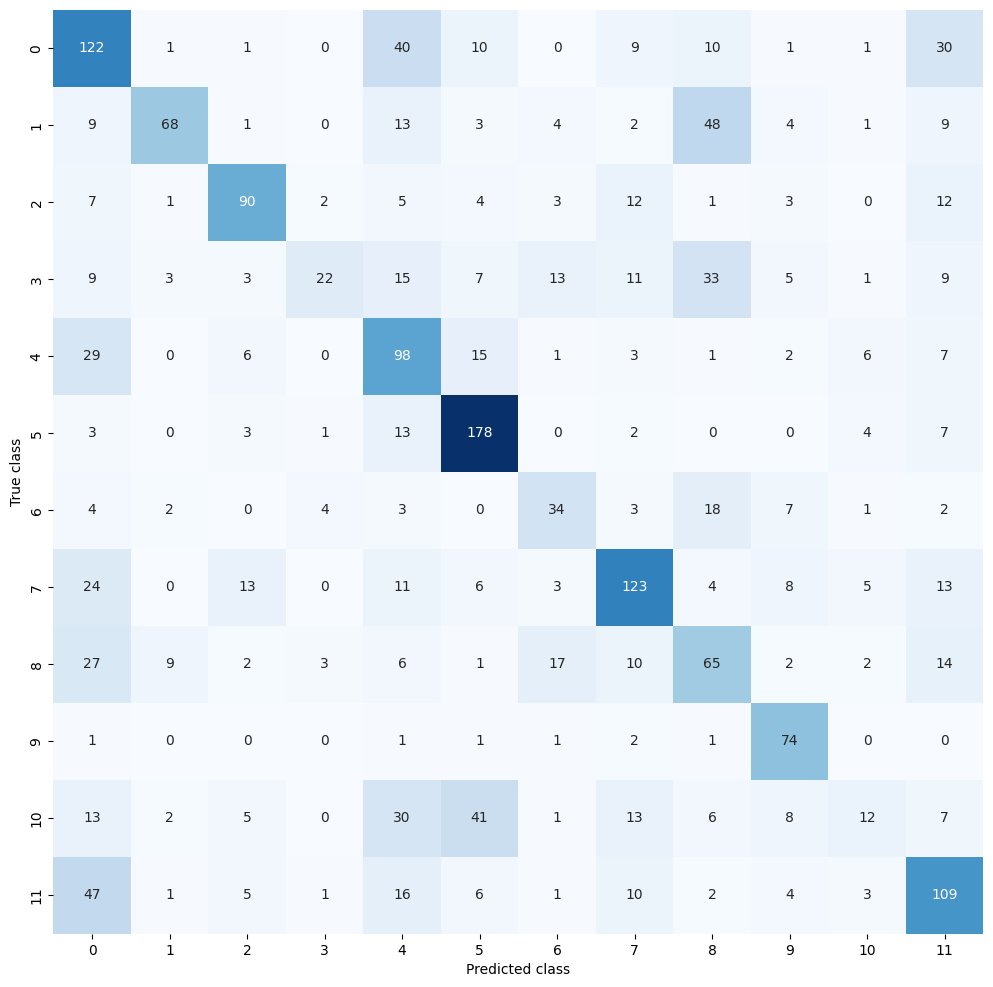

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_val, y_val):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

plot_confusion_matrix(model, X_val, y_val)

60/60 [==============================] - 1s 17ms/step


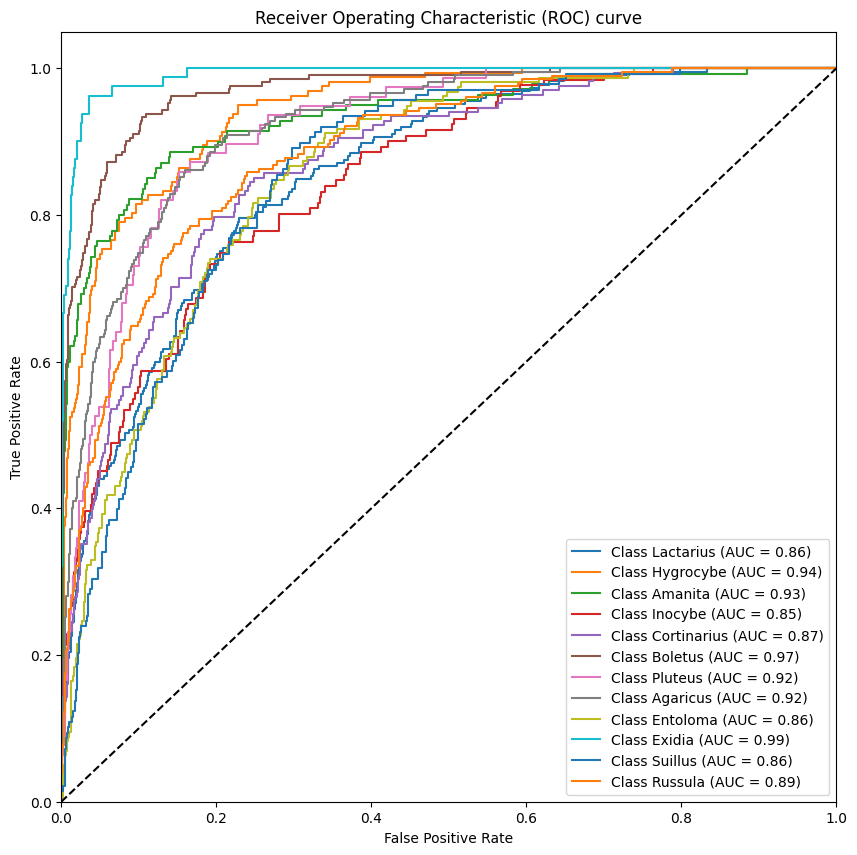

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_roc_and_auc(model, X_val, y_val, categories):
    n_classes = len(categories)

    y_val_binarized = label_binarize(y_val, classes=np.arange(n_classes))
    y_pred = model.predict(X_val)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred[:, i])
        roc_auc[i] = roc_auc_score(y_val_binarized[:, i], y_pred[:, i])

    # Plot ROC curve
    plt.figure(figsize=(10, 10))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {categories[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_and_auc(model, X_val, y_val, categories)

In [ ]:
from sklearn.metrics import classification_report


def print_classification_report(model, X_val, y_val, categories):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    report = classification_report(y_val, y_pred, target_names=categories)
    print(report)

print_classification_report(model, X_val, y_val, categories)

60/60 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

   Lactarius       0.41      0.54      0.47       225
   Hygrocybe       0.78      0.42      0.55       162
     Amanita       0.70      0.64      0.67       140
     Inocybe       0.67      0.17      0.27       131
 Cortinarius       0.39      0.58      0.47       168
     Boletus       0.65      0.84      0.74       211
     Pluteus       0.44      0.44      0.44        78
    Agaricus       0.61      0.59      0.60       210
    Entoloma       0.34      0.41      0.37       158
      Exidia       0.63      0.91      0.74        81
     Suillus       0.33      0.09      0.14       138
     Russula       0.50      0.53      0.51       205

    accuracy                           0.52      1907
   macro avg       0.54      0.51      0.50      1907
weighted avg       0.54      0.52      0.50      1907



In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

y_pred = np.argmax(model.predict(X_val), axis=1)
kappa = cohen_kappa_score(y_val, y_pred)
print("Cohen's Kappa:", kappa)

60/60 [==============================] - 1s 17ms/step
Cohen's Kappa: 0.47247419522152834


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, y_pred)
false_positive_rate = cm.sum(axis=0) / cm.sum()
false_negative_rate = cm.sum(axis=1) / cm.sum()
print("False Positive Rate:", false_positive_rate)
print("False Negative Rate:", false_negative_rate)

60/60 [==============================] - 1s 17ms/step
False Positive Rate: [0.15469324 0.04562139 0.06764552 0.01730467 0.13162035 0.14263241
 0.04090194 0.10487677 0.09910855 0.06187729 0.01887782 0.11484006]
False Negative Rate: [0.11798637 0.08495018 0.07341374 0.06869428 0.08809649 0.11064499
 0.04090194 0.11012061 0.08285265 0.04247509 0.07236497 0.10749869]


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Test_Images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False )

Found 184 images belonging to 12 classes.


In [ ]:
predictions = model.predict(test_generator)


6/6 [==============================] - 136s 27s/step


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = test_generator.classes


In [ ]:
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"Acuratețea pe setul de test este: {accuracy * 100:.2f}%")

Acuratețea pe setul de test este: 9.24%


In [ ]:
X_test = []
y_test = []

test_dataset_path = '/content/drive/MyDrive/Test_Images'
categories = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius','Entoloma','Exidia','Hygrocybe', 'Inocybe', 'Lactarius','Pluteus', 'Russula', 'Suillus']

for idx, category in enumerate(categories):
    category_path = os.path.join(test_dataset_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = preprocess_input(img)
        X_test.append(img)
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:

predictions = model.predict(X_test)


predicted_classes = np.argmax(predictions, axis=1)


print("Predicted class indices:", predicted_classes)


6/6 [==============================] - 1s 95ms/step
Predicted class indices: [ 7  7  7  7  7  7  7  7  7  7  7  7  2  2  2  2  2  1 11  2  2  2  2  2
  2  0  2  5  5  5  5  5  5  5  5  5  5  5  5  5  2  2  5  4  4  5  1  4
  4  4  0  4  5  0  0  6  2  8  8  8  8  0  0  8  8  0  7  8  8 11  8  8
  0  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  7  3 11  3  4  0  8  0  8  0  2  0 11
  4 10  3  0  0  0  0  0  1  0 11  0  0  0  0  4  0  0  0  3  6  8  6  8
 11  6  8  1  6  6  6  6 11  8  8  6 11 11  0 11 11 11 11 11 11 11 11  5
 11 11 11 11 10 10 10 10 10 10  5  5 10 10 10 10 10 10 10 10]


In [ ]:
predicted_labels = [categories[idx] for idx in predicted_classes]
print("Predicted class labels:", predicted_labels)


Predicted class labels: ['Inocybe', 'Inocybe', 'Inocybe', 'Inocybe', 'Inocybe', 'Inocybe', 'Inocybe', 'Inocybe', 'Inocybe', 'Inocybe', 'Inocybe', 'Inocybe', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Amanita', 'Suillus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Boletus', 'Agaricus', 'Boletus', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Exidia', 'Boletus', 'Boletus', 'Exidia', 'Entoloma', 'Entoloma', 'Exidia', 'Amanita', 'Entoloma', 'Entoloma', 'Entoloma', 'Agaricus', 'Entoloma', 'Exidia', 'Agaricus', 'Agaricus', 'Hygrocybe', 'Boletus', 'Lactarius', 'Lactarius', 'Lactarius', 'Lactarius', 'Agaricus', 'Agaricus', 'Lactarius', 'Lactarius', 'Agaricus', 'Inocybe', 'Lactarius', 'Lactarius', 'Suillus', 'Lactarius', 'Lactarius', 'Agaricus', 'Lactarius', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteus', 'Pluteu

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predicted_classes)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.010638297872340425


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import numpy as np

image_paths = [
    '/content/drive/My Drive/poze_reale/1.jpg',
    '/content/drive/My Drive/poze_reale/2.jpg',
    '/content/drive/My Drive/poze_reale/3.jpg',
    '/content/drive/My Drive/poze_reale/4.jpg',
    '/content/drive/My Drive/poze_reale/5.jpg',
    '/content/drive/My Drive/poze_reale/6.jpg',
    '/content/drive/My Drive/poze_reale/7.jpg',
    '/content/drive/My Drive/poze_reale/8.jpg',
    '/content/drive/My Drive/poze_reale/9.jpg',
    '/content/drive/My Drive/poze_reale/10.jpg',
    '/content/drive/My Drive/poze_reale/11.jpg'

]

for image_path in image_paths:
    image = load_img(image_path, target_size=(224, 224))
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    pred = model.predict(image)
    class_index = np.argmax(pred)

    print("Predicted class index for image", image_path, ":", class_index)
    print("Predicted probabilities:", pred)

1/1 [==============================] - 0s 246ms/step
Predicted class index for image /content/drive/My Drive/poze_reale/1.jpg : 2
Predicted probabilities: [[9.1515110e-05 8.8781280e-06 9.9732757e-01 7.2950371e-07 1.9303159e-05
  2.2792071e-04 4.1486311e-07 8.1998971e-04 6.0854369e-08 6.7004531e-09
  2.9818541e-06 1.5007054e-03]]
1/1 [==============================] - 0s 26ms/step
Predicted class index for image /content/drive/My Drive/poze_reale/2.jpg : 5
Predicted probabilities: [[9.50465619e-06 3.74172887e-10 1.70260307e-06 7.90393029e-10
  1.13398073e-05 9.99492288e-01 9.99544891e-10 4.77076618e-08
  1.71703429e-09 1.36854616e-11 4.85103694e-04 1.09242876e-07]]
1/1 [==============================] - 0s 28ms/step
Predicted class index for image /content/drive/My Drive/poze_reale/3.jpg : 2
Predicted probabilities: [[1.4645295e-03 4.7476673e-03 7.6949525e-01 1.5589361e-04 8.1981003e-04
  1.4329436e-01 5.2431680e-02 1.9001346e-02 7.6446316e-04 3.6101441e-03
  9.9483586e-04 3.2200424e-03